_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install matplotlib==3.7.1
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment.

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`).

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [119]:
# YOUR CODE HERE
!pip install shap

import pandas as pd
import shap
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, ConfusionMatrixDisplay, \
    RocCurveDisplay, roc_auc_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor
from sklearn.inspection import permutation_importance
from pdpbox.pdp import PDPIsolate, PDPInteract
from pdpbox.info_plots import InteractTargetPlot
import matplotlib.pyplot as plt

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [182]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'

# YOUR CODE HERE
df = pd.read_csv(url, parse_dates = ['Inspection Date'], index_col = 'Inspection Date').sort_index()

**Task 1 Test**

In [183]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [184]:
'''T2. Identify data leakage column.'''
# YOUR CODE HERE
leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [185]:
'''T2 Test'''
# This is a hidden test.
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [186]:
'''T3. Write wrangle function.'''
def wrangle(df):
    return df
# YOUR CODE HERE

df = df.drop(columns = ['DBA Name', 'AKA Name', 'Address', 'Location', 'Inspection ID', 'License #', 'State'])

cutoff = 500
drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
df.drop(columns=drop_cols, inplace=True)

df = df.drop(columns = leaky_col)

df = wrangle(df)

In [187]:
df.head()

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60634.0,License Re-Inspection,41.938443,-87.768318,0
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60613.0,License Re-Inspection,41.961606,-87.675967,0
2010-01-05,Daycare Above and Under 2 Years,Risk 1 (High),CHICAGO,60652.0,License,41.742993,-87.721558,0
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60666.0,Canvass,42.008536,-87.914428,1
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60639.0,Complaint,41.919224,-87.767734,1


**Task 3 Test**

In [188]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [189]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# YOUR CODE HERE
y = df[target]
X = df.drop(columns = target)

**Task 4 Test**

In [190]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [191]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE
mask = X.index.year < 2017

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

**Task 5 Testing**

In [192]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [193]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [194]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [195]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
model_bag = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1)
)


model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [196]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary.

In [197]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    GradientBoostingClassifier(random_state = 42, n_estimators = 75)
)

model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [198]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [199]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9078107442561025
Validation accuracy: 0.6795519873129151

Boosting Model
Training accuracy: 0.7553015994453344
Validation accuracy: 0.7029438001784122


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

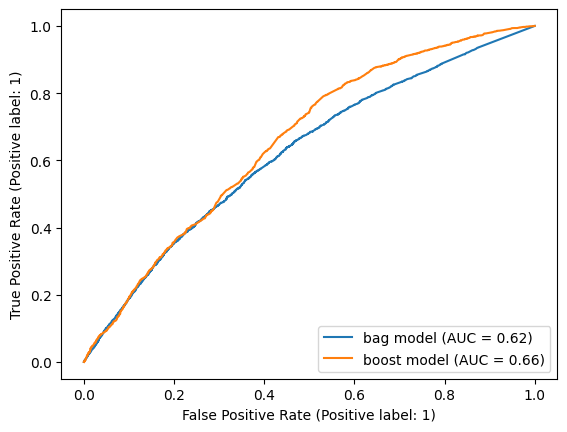

In [200]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
plot_roc_curve = RocCurveDisplay.from_estimator

bagg = plot_roc_curve(
    model_bag,
    X_val,
    y_val,
    name = 'bag model'
)
boostt = plot_roc_curve(
    model_boost,
    X_val,
    y_val,
    ax = bagg.ax_,
    name = 'boost model'
)

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`.

In [201]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# YOUR CODE HERE
model_cr = classification_report(y_val, model_boost.predict(X_val))

print(model_cr)

              precision    recall  f1-score   support

           0       0.70      1.00      0.82      7092
           1       0.50      0.01      0.02      2997

    accuracy                           0.70     10089
   macro avg       0.60      0.50      0.42     10089
weighted avg       0.64      0.70      0.59     10089



**Task 10 Testing**

In [202]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [203]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
perm_imp = permutation_importance(model_boost, X_val, y_val, random_state = 42)

data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
permutation_importances = pd.DataFrame(data_perm, index = X_val.columns).sort_values('imp_mean')

permutation_importances

,imp_mean,imp_std
Zip,-0.000218,0.000761
City,-0.000198,0.000063
Longitude,-0.000020,0.000656
Latitude,0.000714,0.000368
Inspection Type,0.000793,0.000765
Facility Type,0.000932,0.000374
Risk,0.000991,0.000258


**Task 11 Testing**

In [205]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

In [206]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
two_features = ['Longitude', 'Latitude']
# YOUR CODE HERE
pdp_interact = PDPInteract
twoint = pdp_interact(
    model_boost,
    df = X_val.dropna(),
    model_features = X_val.columns,
    features = two_features,
    feature_names = ('Long', 'Lat'),
    n_classes = 2
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/100 [00:00<?, ?it/s]

What do you think? Is there a relationship between location and failing a food saftey inspection? Answer below.

This task will not be autograded - but it is part of completing the challenge.